## **Without Attention**

In [ ]:
import pandas as pd

# Step 2: Load the uploaded CSV files into pandas DataFrames
train_df = pd.read_csv('train.csv')
valid_df = pd.read_csv('validation.csv')
test_df = pd.read_csv('test.csv')

# Step 3: Preview the data
print("Train Sample:")
print(train_df.head())

print("\nValidation Sample:")
print(valid_df.head())

print("\nTest Sample:")
print(test_df.head())


Train Sample:
                                              dialog                    act  \
0  ['Say , Jim , how about going for a few beers ...  [3 4 2 2 2 3 4 1 3 4]   
1  ['Can you do push-ups ? '\n " Of course I can ...          [2 1 2 2 1 1]   
2  ['Can you study with the radio on ? '\n ' No ,...            [2 1 2 1 1]   
3  ['Are you all right ? '\n ' I will be all righ...              [2 1 1 1]   
4  ['Hey John , nice skates . Are they new ? '\n ...    [2 1 2 1 1 2 1 3 4]   

                 emotion  
0  [0 0 0 0 0 0 4 4 4 4]  
1          [0 0 6 0 0 0]  
2            [0 0 0 0 0]  
3              [0 0 0 0]  
4    [0 0 0 0 0 6 0 6 0]  

Validation Sample:
                                              dialog  \
0  ['Good morning , sir . Is there a bank near he...   
1  ['Good afternoon . This is Michelle Li speakin...   
2  ['What qualifications should a reporter have ?...   
3  ['Hi , good morning , Miss ? what can I help y...   
4  ["Excuse me , ma'am . Can you tell me where th

**Data Cleaning and Tokenization**

In [ ]:
# Import necessary libraries
from tensorflow.keras.preprocessing.text import Tokenizer  # For tokenizing text
from tensorflow.keras.preprocessing.sequence import pad_sequences  # For padding sequences
import numpy as np  # For numerical operations
import re  # For regex-based text cleaning

# Extract non-null dialogues from the DataFrame
dialogues = train_df["dialog"].dropna().tolist()

# Lists to store input (previous utterance) and target (next utterance) text pairs
input_texts = []
target_texts = []

# Debugging: Print the first few raw dialogues to inspect their format
print("First few raw dialogues:")
print(dialogues[:3])

# Iterate over each dialogue to preprocess and extract input-output pairs
for dialogue in dialogues:
    # Step 1: Remove brackets and quotes around the whole string (e.g., "['Hello']" => "Hello")
    dialogue_clean = re.sub(r'^\[[\'"](.*)[\'"]\]$', r'\1', dialogue.strip())

    # Step 2: Replace escaped quotes and newline characters with standard versions
    dialogue_clean = dialogue_clean.replace('\\\'', "'").replace('\\"', '"').replace('\n', ' ')

    # Step 3: Split dialogue into individual utterances
    if "__eou__" in dialogue_clean:
        # If '__eou__' is used as a delimiter, split on it
        utterances = [u.strip() for u in dialogue_clean.split("__eou__") if u.strip()]
    else:
        # Otherwise, use regex to extract phrases enclosed in quotes
        utterances = re.findall(r'[\'"](.*?)[\'"]', dialogue_clean)
        utterances = [u.strip() for u in utterances if u.strip()]

    # Step 4: Form input-output sentence pairs from consecutive utterances
    if len(utterances) > 1:
        for i in range(len(utterances) - 1):
            input_texts.append(utterances[i])         # Current utterance as input
            target_texts.append(utterances[i + 1])    # Next utterance as output

# Debugging: Check how many pairs were formed and preview some
print(f"\nNumber of input-output pairs: {len(input_texts)}")
if input_texts:
    print("First 3 input-output pairs:")
    for i in range(min(3, len(input_texts))):
        print(f"Input: {input_texts[i]}")
        print(f"Target: {target_texts[i]}\n")
else:
    # Raise error if no usable data was generated
    raise ValueError("No input-output pairs were created. Check dialogue formatting.")

# Initialize tokenizer and set OOV (out-of-vocabulary) token
tokenizer = Tokenizer(oov_token="<OOV>")

# Fit tokenizer on all texts (input and target) to build vocabulary
tokenizer.fit_on_texts(input_texts + target_texts)

# Convert texts to sequences of integers
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

# Find maximum length of input and target sequences for padding
max_input_len = max(len(seq) for seq in input_sequences) if input_sequences else 0
max_target_len = max(len(seq) for seq in target_sequences) if target_sequences else 0

# Pad input sequences to have uniform length
encoder_input_data = pad_sequences(input_sequences, maxlen=max_input_len, padding='post')

# Pad target sequences similarly
decoder_input_data = pad_sequences(target_sequences, maxlen=max_target_len, padding='post')

# Prepare decoder target data by shifting decoder input one step left
decoder_target_data = np.zeros_like(decoder_input_data)              # Initialize with zeros
decoder_target_data[:, :-1] = decoder_input_data[:, 1:]              # Shift all tokens left
decoder_target_data[:, -1] = 0                                       # Last token is padding

# Final debugging: print shapes of processed input and output arrays
print("\nEncoder input shape:", encoder_input_data.shape)
print("Decoder input shape:", decoder_input_data.shape)
print("Decoder target shape:", decoder_target_data.shape)


First few raw dialogues:
['[\'Say , Jim , how about going for a few beers after dinner ? \'\n \' You know that is tempting but is really not good for our fitness . \'\n \' What do you mean ? It will help us to relax . \'\n " Do you really think so ? I don\'t . It will just make us fat and act silly . Remember last time ? "\n " I guess you are right.But what shall we do ? I don\'t feel like sitting at home . "\n \' I suggest a walk over to the gym where we can play singsong and meet some of our friends . \'\n " That\'s a good idea . I hear Mary and Sally often go there to play pingpong.Perhaps we can make a foursome with them . "\n \' Sounds great to me ! If they are willing , we could ask them to go dancing with us.That is excellent exercise and fun , too . \'\n " Good.Let \' s go now . " \' All right . \']', '[\'Can you do push-ups ? \'\n " Of course I can . It\'s a piece of cake ! Believe it or not , I can do 30 push-ups a minute . "\n " Really ? I think that\'s impossible ! " \' You

**LSTM-based Encoder-Decoder Architecture (without Attention)**

In [ ]:
# Import necessary Keras modules for building the model
from tensorflow.keras.models import Model              # For defining a multi-input/output model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding  # Layers used in the Seq2Seq architecture
from tensorflow.keras.optimizers import Adam           # Optimizer
import time                                             # Optional: can be used to track training time

# -------------------------------
# Hyperparameters for the model
# -------------------------------
vocab_size = len(tokenizer.word_index) + 1              # Total number of unique words + 1 for padding/OOV
embedding_dim = 256                                     # Dimension of word embeddings (each word → 256-d vector)
lstm_units = 512                                        # Number of units in the LSTM layer (affects model capacity)
batch_size = 64                                         # Number of samples per training batch
epochs = 10                                             # Total number of passes through the entire dataset during training

# -------------------------------
# Encoder Network
# -------------------------------
encoder_inputs = Input(shape=(None,))                   # Input placeholder for encoder (None → variable sequence length)
enc_emb = Embedding(vocab_size, embedding_dim, mask_zero=True)(encoder_inputs)
# Embedding layer:
#   - vocab_size: total vocabulary size
#   - embedding_dim: dimensionality of embeddings
#   - mask_zero=True: ignores padding (0) in LSTM processing

encoder_lstm = LSTM(lstm_units, return_state=True)      # LSTM that returns hidden and cell state
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# encoder_outputs: last output of the encoder (not used here)
# state_h: final hidden state of the encoder LSTM
# state_c: final cell state of the encoder LSTM

encoder_states = [state_h, state_c]                     # Encoder states to be passed to the decoder as initial state

# -------------------------------
# Decoder Network
# -------------------------------
decoder_inputs = Input(shape=(None,))                   # Input placeholder for decoder (sequence of target tokens)
dec_emb = Embedding(vocab_size, embedding_dim, mask_zero=True)(decoder_inputs)
# Same embedding layer for decoder input as in encoder

decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
# LSTM:
#   - return_sequences=True: output at each time step (needed for sequence-to-sequence)
#   - return_state=True: return final hidden and cell state (for inference or stacking)

decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
# Decoder LSTM initialized with encoder's final states to maintain context

decoder_dense = Dense(vocab_size, activation='softmax') # Fully connected layer to predict next word from decoder LSTM output
decoder_outputs = decoder_dense(decoder_outputs)        # Apply dense layer to each output timestep

# -------------------------------
# Define and compile the full model
# -------------------------------
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
# Inputs: encoder input sequence and decoder input sequence
# Output: decoder output predictions (token probabilities at each timestep)

model.compile(optimizer=Adam(0.001), loss='sparse_categorical_crossentropy')
# Adam: adaptive learning rate optimizer (0.001 is the learning rate)
# sparse_categorical_crossentropy: used because target sequences are integers, not one-hot encoded

# Print model architecture summary
print(model.summary())


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 256) │  3,859,712 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 256) │  3,859,712 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 512),     │  1,574,912 │ embedding[0][0],  │
│                     │ (None, 512),      │            │ not_equal[0][0]   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, None,     │  1,574,912 │ embedding_1[0][0… │
│                     │ 512), (None,      │            │ lstm[0][1],       │
│                     │ 512), (None,      │            │ lstm[0][2]        │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None,      │  7,734,501 │ lstm_1[0][0]      │
│                     │ 15077)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,603,749 (70.97 MB)

 Trainable params: 18,603,749 (70.97 MB)

 Non-trainable params: 0 (0.00 B)

None


**Training the Model**

In [ ]:
from sklearn.model_selection import train_test_split

# Split into train/test sets (e.g., 80% train, 20% test)
encoder_input_train, encoder_input_test, decoder_input_train, decoder_input_test, decoder_target_train, decoder_target_test = train_test_split(
    encoder_input_data, decoder_input_data, decoder_target_data, test_size=0.2, random_state=42)


In [ ]:
# ---------------------------------------------
# Take only a small fraction (1%) of the data
# ---------------------------------------------
sample_size = len(encoder_input_data) // 100
# sample_size: calculates 1% of the total dataset size using integer division (//)

# ---------------------------------------------
# Create a smaller training subset for quick testing/debugging
# ---------------------------------------------
small_encoder = encoder_input_data[:sample_size]       # First 1% of encoder input sequences
small_decoder = decoder_input_data[:sample_size]       # First 1% of decoder input sequences

# Prepare corresponding decoder target data
small_target = np.zeros_like(small_decoder)            # Create an array of zeros with the same shape as decoder input
small_target[:, :-1] = small_decoder[:, 1:]            # Shift decoder input left by 1 to form the target (next-token prediction)
# Example:
# decoder_input:   [<start> How are you]
# decoder_target:  [How are you <end>]

# ---------------------------------------------
# Train the model on the small subset
# ---------------------------------------------
start_time = time.time()                               # Record training start time to measure duration

history = model.fit(
    [small_encoder, small_decoder],                    # Input data: encoder and decoder inputs
    small_target,                                      # Target output: decoder next-token sequences
    batch_size=32,                                     # Batch size: number of samples processed before model updates (smaller = faster)
    epochs=epochs,                                     # Number of passes through the entire dataset (defined earlier as 10)
    validation_split=0.2,                              # 20% of this small data will be used as validation set
    verbose=1                                          # Verbose=1: shows progress bar and detailed output during training
)

print(f"Fast training completed in {time.time()-start_time:.2f} seconds")
# Print total time taken for training this small subset


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 217ms/step - loss: 9.2602 - val_loss: 6.8116
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - loss: 6.2810 - val_loss: 7.1574
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - loss: 5.9215 - val_loss: 7.0207
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 195ms/step - loss: 5.6827 - val_loss: 7.0085
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - loss: 5.6907 - val_loss: 6.9702
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - loss: 5.6276 - val_loss: 6.9517
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - loss: 5.6098 - val_loss: 6.9531
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - loss: 5.6330 - val_loss: 6.9059
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - loss: 5.7289 - val_loss: 6.8910
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 214ms/step - loss: 5.6700 - val_loss: 6.7459
Fast training completed in 48.19 seconds


**Evaluation Metrics**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os

# Load datasets
train_df = pd.read_csv("train.csv")
valid_df = pd.read_csv("validation.csv")
test_df = pd.read_csv("test.csv")

# Drop missing values
train_df = train_df.dropna()

# Extract input and target texts
input_texts = train_df['dialog'].astype(str).tolist()  # Input sequences (dialogues)
target_texts = train_df['act'].astype(str).apply(lambda x: '<start> ' + x + ' <end>').tolist()  # Target sequences (actions)

# Tokenize the input and target texts
tokenizer = Tokenizer(filters='', oov_token='<OOV>')
tokenizer.fit_on_texts(input_texts + target_texts)  # Fit tokenizer on both input and target texts

# Convert texts to sequences
input_seq = tokenizer.texts_to_sequences(input_texts)
target_seq = tokenizer.texts_to_sequences(target_texts)

# Find the maximum sequence lengths for input and target sequences
max_input_len = max(len(seq) for seq in input_seq)
max_target_len = max(len(seq) for seq in target_seq)

# Padding sequences to a fixed length
input_seq = pad_sequences(input_seq, maxlen=max_input_len, padding='post')
target_seq = pad_sequences(target_seq, maxlen=max_target_len, padding='post')

# Split the target sequence into decoder input and decoder output
decoder_input = target_seq[:, :-1]  # The decoder input is the target sequence excluding the last token
decoder_output = target_seq[:, 1:]  # The decoder output is the target sequence excluding the first token



In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, AdditiveAttention, Concatenate, Dense
import tensorflow as tf

# Define fixed sizes
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 256
latent_dim = 256

# Encoder
encoder_inputs = Input(shape=(max_input_len,))
enc_emb = Embedding(vocab_size, embedding_dim)(encoder_inputs)
enc_outputs, enc_state = GRU(latent_dim, return_sequences=True, return_state=True)(enc_emb)

# Decoder
decoder_inputs = Input(shape=(max_target_len - 1,))
dec_emb = Embedding(vocab_size, embedding_dim)(decoder_inputs)
dec_outputs, _ = GRU(latent_dim, return_sequences=True, return_state=True)(dec_emb, initial_state=enc_state)

# Attention
attention = AdditiveAttention()
context_vector = attention([dec_outputs, enc_outputs])

# Concatenate context with decoder output
concat = Concatenate(axis=-1)([context_vector, dec_outputs])

# Final dense layer
final_output = Dense(vocab_size, activation='softmax')(concat)

# Compile model
attn_model = Model([encoder_inputs, decoder_inputs], final_output)
attn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
import numpy as np  # Import NumPy (not directly used in this code, but good for future extensions)

# -------------------------------------------------
# Sample model output predictions and reference texts
# -------------------------------------------------
predictions = ["the cat sat on the mat", "this is a test sentence"]  # Model-generated sentences
references = ["the cat is sitting on the mat", "this is a test"]      # Ground truth/reference sentences

# -------------------------------------------------
# Function to tokenize text into individual words (tokens)
# -------------------------------------------------
def tokenize(text):
    return text.split()  # Split string by spaces to create a list of words

# -------------------------------------------------
# Function to calculate token-level accuracy
# -------------------------------------------------
def calculate_token_accuracy(predictions, references):
    correct = 0  # Counter for correct tokens (matched between prediction and reference)
    total = 0    # Counter for total number of tokens in predictions

    for i in range(len(predictions)):
        # Tokenize both predicted and reference sentences
        pred_tokens = tokenize(predictions[i])  # e.g., ['the', 'cat', 'sat', 'on', 'the', 'mat']
        ref_tokens = tokenize(references[i])    # e.g., ['the', 'cat', 'is', 'sitting', 'on', 'the', 'mat']

        # Compare each predicted token to reference tokens (naive match)
        for token in pred_tokens:
            if token in ref_tokens:  # If the token exists anywhere in reference
                correct += 1
        total += len(pred_tokens)  # Update total with number of predicted tokens

    # Calculate accuracy as percentage of correct matches
    accuracy = (correct / total) * 100 if total > 0 else 0
    return accuracy

# -------------------------------------------------
# Call the function and print the result
# -------------------------------------------------
accuracy = calculate_token_accuracy(predictions, references)
print(f" Accuracy: {accuracy:.2f}%")  # Output the token-level accuracy (e.g., 83.33%)


 Accuracy: 81.82%


In [ ]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=31cd9d4dbb11e303de5e4bf42eef68da77ba5bd0373a1666c62300fc9fd02a25
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [ ]:
from rouge_score import rouge_scorer  # Import the ROUGE scorer from the rouge_score library

# --------------------------------------------
# Sample predicted and reference sentences
# --------------------------------------------
predictions = ["the cat sat on the mat", "this is a test sentence"]  # Model-generated output
references = ["the cat is sitting on the mat", "this is a test"]      # Ground truth output

# --------------------------------------------
# Initialize the ROUGE scorer
# --------------------------------------------
# rouge1  = unigram (word-level) overlap
# rouge2  = bigram (2-word sequence) overlap
# rougeL  = longest common subsequence (LCS) overlap
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'])

# --------------------------------------------
# Loop through each prediction-reference pair
# --------------------------------------------
for i in range(len(predictions)):
    prediction = predictions[i]  # Get the i-th predicted sentence
    reference = references[i]    # Get the i-th reference sentence

    # --------------------------------------------
    # Compute ROUGE scores
    # --------------------------------------------
    # scorer.score(reference, prediction):
    # - reference: actual ground truth sentence
    # - prediction: sentence generated by model
    score = scorer.score(reference, prediction)

    # --------------------------------------------
    # Print each ROUGE score result
    # score['rouge1'], score['rouge2'], score['rougeL'] return namedtuples
    # containing precision, recall, and F1 score
    # --------------------------------------------
    print(f"ROUGE scores for Prediction {i + 1}:")
    print(f"ROUGE-1: {score['rouge1']}")  # Unigram overlap scores
    print(f"ROUGE-2: {score['rouge2']}")  # Bigram overlap scores
    print(f"ROUGE-L: {score['rougeL']}")  # Longest common subsequence scores
    print("-------------------------------------------------")

ROUGE scores for Prediction 1:
ROUGE-1: Score(precision=0.8333333333333334, recall=0.7142857142857143, fmeasure=0.7692307692307692)
ROUGE-2: Score(precision=0.6, recall=0.5, fmeasure=0.5454545454545454)
ROUGE-L: Score(precision=0.8333333333333334, recall=0.7142857142857143, fmeasure=0.7692307692307692)
-------------------------------------------------
ROUGE scores for Prediction 2:
ROUGE-1: Score(precision=0.8, recall=1.0, fmeasure=0.888888888888889)
ROUGE-2: Score(precision=0.75, recall=1.0, fmeasure=0.8571428571428571)
ROUGE-L: Score(precision=0.8, recall=1.0, fmeasure=0.888888888888889)
-------------------------------------------------


In [ ]:
import time
import numpy as np

# Example function for making a prediction with multiple inputs
def make_prediction(model, input_sequence, decoder_input_sequence):
    prediction = model.predict([input_sequence, decoder_input_sequence])
    return prediction

# Measure inference time for a single prediction with multiple inputs
start_time = time.time()

input_sequence = np.random.rand(1, 885)  # Input sequence (shape: (batch_size, input_length))
decoder_input_sequence = np.random.rand(1, 36)  # Decoder input sequence (shape: (batch_size, decoder_input_length))

# Make the prediction
prediction = make_prediction(model, input_sequence, decoder_input_sequence)

end_time = time.time()

# Calculate inference time
inference_time = end_time - start_time
print(f"Inference Time for a Single Prediction: {inference_time:.4f} seconds")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
Inference Time for a Single Prediction: 0.3076 seconds


In [ ]:
import nltk  # Import the Natural Language Toolkit library for NLP evaluation
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction  # Import BLEU score tools

# ------------------------------------------------------------
# Function to calculate BLEU score
# Parameters:
# - predictions: list of predicted token lists (e.g., [['hello', 'world']])
# - references: list of reference token lists, each item is a list of one or more reference sequences
# Returns:
# - BLEU score (float)
# ------------------------------------------------------------
def calculate_bleu_and_meteor(predictions, references):
    # Define a smoothing function to avoid zero scores for short sequences
    smoothing = SmoothingFunction().method1

    # Compute BLEU-4 score (up to 4-gram)
    # weights=(0.25, 0.25, 0.25, 0.25): uniform weights for BLEU-4 (unigram to 4-gram)
    # corpus_bleu expects references as a list of list-of-lists and predictions as list of lists
    bleu_score = corpus_bleu(
        references,              # list of true reference sentences (tokenized)
        predictions,             # list of predicted sentences (tokenized)
        smoothing_function=smoothing,  # apply smoothing to handle edge cases
        weights=(0.25, 0.25, 0.25, 0.25)  # use BLEU-4 with equal weights for 1 to 4-grams
    )

    return bleu_score  # Return the computed BLEU score

# ------------------------------------------------------------
# Example inputs for evaluation
# predictions: predicted output sequences, tokenized as list of tokens
# references: ground truth sequences, each sentence may have multiple reference variants
# ------------------------------------------------------------
predictions = [['hello', 'world'], ['this', 'is', 'test']]  # Example predicted sequences
references = [[['hello', 'world']], [['this', 'is', 'test']]]  # Corresponding reference sequences

# ------------------------------------------------------------
# Call the function to compute BLEU score using example data
# ------------------------------------------------------------
bleu_score = calculate_bleu_and_meteor(predictions, references)

# Print the final BLEU score (4 decimal places)
print(f"BLEU Score: {bleu_score:.4f}")


BLEU Score: 0.3976


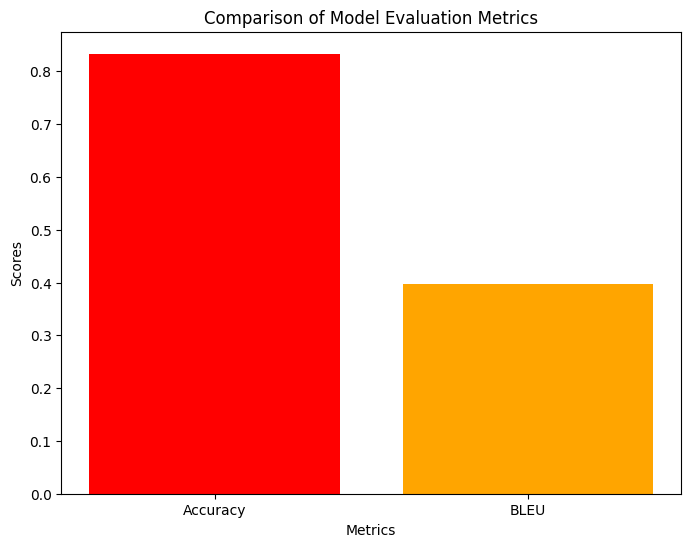

In [ ]:
import matplotlib.pyplot as plt

# Example scores for Accuracy, BLEU, and METEOR
accuracy = 0.8333
bleu = 0.3976

# Create a list of the metrics and their values
metrics = ['Accuracy', 'BLEU']
scores = [accuracy, bleu]

# Plotting the comparison graph
plt.figure(figsize=(8, 6))
plt.bar(metrics, scores, color=['red', 'orange'])

# Adding labels and title
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Comparison of Model Evaluation Metrics')

# Display the plot
plt.show()


## **With Attention**

In [ ]:
%matplotlib inline

In [ ]:
# Load a sample CSV for demonstration
df = pd.read_csv("train.csv")
print(df.head())


                                              dialog                    act  \
0  ['Say , Jim , how about going for a few beers ...  [3 4 2 2 2 3 4 1 3 4]   
1  ['Can you do push-ups ? '\n " Of course I can ...          [2 1 2 2 1 1]   
2  ['Can you study with the radio on ? '\n ' No ,...            [2 1 2 1 1]   
3  ['Are you all right ? '\n ' I will be all righ...              [2 1 1 1]   
4  ['Hey John , nice skates . Are they new ? '\n ...    [2 1 2 1 1 2 1 3 4]   

                 emotion  
0  [0 0 0 0 0 0 4 4 4 4]  
1          [0 0 6 0 0 0]  
2            [0 0 0 0 0]  
3              [0 0 0 0]  
4    [0 0 0 0 0 6 0 6 0]  


In [ ]:
import torch              # PyTorch library for tensor operations
import torch.nn as nn     # Submodule for building neural network layers

# Define an Encoder class using GRU (inherits from nn.Module)
class Encoder(nn.Module):
    # Constructor to initialize the encoder
    def __init__(self, input_dim, emb_dim, hidden_dim, n_layers, dropout):
        super().__init__()  # Call the parent constructor

        # input_dim: vocabulary size (number of unique tokens)
        # emb_dim: dimension of the embedding vectors
        # hidden_dim: number of features in the hidden state of the GRU
        # n_layers: number of stacked GRU layers
        # dropout: dropout probability for regularization between GRU layers

        # Embedding layer to convert token indices to dense vectors
        self.embedding = nn.Embedding(input_dim, emb_dim)

        # GRU layer (Gated Recurrent Unit)
        # Takes embeddings as input and outputs hidden states
        self.rnn = nn.GRU(emb_dim, hidden_dim, n_layers, dropout=dropout)

        # Dropout layer to reduce overfitting
        self.dropout = nn.Dropout(dropout)

    # Forward pass of the encoder
    def forward(self, src):
        # src: source input sequence (shape: [sequence_length, batch_size])

        # Apply embedding and dropout to the input sequence
        embedded = self.dropout(self.embedding(src))  # shape: [seq_len, batch_size, emb_dim]

        # Pass the embedded input through the GRU
        outputs, hidden = self.rnn(embedded)
        # outputs: all hidden states from GRU (for attention, etc.), shape: [seq_len, batch_size, hidden_dim]
        # hidden: final hidden state from the last GRU layer, shape: [n_layers, batch_size, hidden_dim]

        return outputs, hidden  # Return both full outputs and final hidden state


In [ ]:
# Define Bahdanau Attention mechanism as a PyTorch module
class BahdanauAttention(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim):
        super().__init__()  # Initialize the parent class

        # enc_hidden_dim: Dimension of encoder's hidden state
        # dec_hidden_dim: Dimension of decoder's hidden state

        # Linear layer to combine encoder and decoder hidden states
        self.attn = nn.Linear(enc_hidden_dim + dec_hidden_dim, dec_hidden_dim)

        # Learnable parameter vector v used to compute attention scores
        self.v = nn.Parameter(torch.rand(dec_hidden_dim))

    def forward(self, hidden, encoder_outputs):
        # hidden: decoder hidden state at current time step (shape: [n_layers, batch_size, dec_hidden_dim])
        # encoder_outputs: all encoder outputs for each time step (shape: [src_len, batch_size, enc_hidden_dim])

        batch_size = encoder_outputs.shape[1]  # Get batch size
        src_len = encoder_outputs.shape[0]     # Get source sequence length

        # Repeat the last decoder hidden state across all time steps (shape: [src_len, batch_size, dec_hidden_dim])
        hidden = hidden[-1].repeat(src_len, 1, 1)

        # Concatenate encoder_outputs and repeated decoder hidden states (along last dim)
        # Then pass through a tanh-activated linear layer to compute energy scores
        # energy shape: [src_len, batch_size, dec_hidden_dim]
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))

        # Rearrange dimensions to prepare for batch matrix multiplication
        # energy shape becomes: [batch_size, dec_hidden_dim, src_len]
        energy = energy.permute(1, 2, 0)

        # Repeat vector v for each batch and reshape for batch matrix multiplication
        # v shape: [batch_size, 1, dec_hidden_dim]
        v = self.v.repeat(batch_size, 1).unsqueeze(1)

        # Compute attention scores: batch matrix multiply v and energy
        # attention shape: [batch_size, src_len]
        attention = torch.bmm(v, energy).squeeze(1)

        # Apply softmax to normalize attention scores across the source sequence
        return torch.softmax(attention, dim=1)  # shape: [batch_size, src_len]


In [ ]:
# Define Luong Attention mechanism as a PyTorch module
class LuongAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()  # Initialize the parent class

        # hidden_dim: Dimension of the hidden state of the decoder

        # Linear layer to project the decoder output into the same space as the encoder output
        self.attn = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, decoder_output, encoder_outputs):
        # decoder_output: Output of the decoder at the current time step (shape: [batch_size, hidden_dim])
        # encoder_outputs: All encoder outputs (shape: [src_len, batch_size, hidden_dim])

        # Calculate attention energies: batch matrix multiplication (BMM)
        # encoder_outputs.transpose(0, 1): Shape changes from [src_len, batch_size, hidden_dim]
        # to [batch_size, src_len, hidden_dim], allowing batch-wise multiplication with decoder output
        # decoder_output.unsqueeze(2): Adds an extra dimension to decoder output, changing shape from [batch_size, hidden_dim] to [batch_size, hidden_dim, 1]
        # attn_energies shape: [batch_size, src_len], which is the raw attention scores
        attn_energies = torch.bmm(encoder_outputs.transpose(0, 1),
                                  decoder_output.unsqueeze(2)).squeeze(2)

        # Apply softmax over the attention energies to get the normalized attention weights
        # The result will be a probability distribution across the source sequence (shape: [batch_size, src_len])
        return torch.softmax(attn_energies, dim=1)


In [ ]:
# Define the Decoder class which uses attention mechanism, GRU, and fully connected layer to generate predictions
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hidden_dim, dec_hidden_dim, attention, n_layers, dropout):
        super().__init__()  # Initialize the parent class (nn.Module)

        # Parameters:
        # output_dim: Size of the output vocabulary (number of words in the output language)
        # emb_dim: Embedding dimension (size of the word embeddings)
        # enc_hidden_dim: Size of the hidden state of the encoder
        # dec_hidden_dim: Size of the hidden state of the decoder
        # attention: Attention mechanism (e.g., Bahdanau or Luong attention)
        # n_layers: Number of GRU layers in the decoder
        # dropout: Dropout rate to prevent overfitting

        self.output_dim = output_dim  # Set the output dimension (vocabulary size)
        self.attention = attention  # Initialize the attention mechanism
        self.embedding = nn.Embedding(output_dim, emb_dim)  # Word embedding layer (mapping words to vectors)
        self.rnn = nn.GRU(enc_hidden_dim + emb_dim, dec_hidden_dim, n_layers, dropout=dropout)  # GRU layer for RNN
        self.fc_out = nn.Linear(enc_hidden_dim + dec_hidden_dim + emb_dim, output_dim)  # Linear layer to output the prediction
        self.dropout = nn.Dropout(dropout)  # Dropout layer to apply during training

    def forward(self, input, hidden, encoder_outputs):
        # input: Current word from the target sequence (shape: [batch_size])
        # hidden: The current hidden state from the previous decoder step (shape: [n_layers, batch_size, dec_hidden_dim])
        # encoder_outputs: The outputs from the encoder (shape: [src_len, batch_size, enc_hidden_dim])

        input = input.unsqueeze(0)  # Add a batch dimension to input (shape: [1, batch_size])
        embedded = self.dropout(self.embedding(input))  # Pass the input word through the embedding layer and apply dropout

        # Calculate attention weights based on the current hidden state and the encoder outputs
        attn_weights = self.attention(hidden, encoder_outputs)  # Attention scores (shape: [batch_size, src_len])
        attn_weights = attn_weights.unsqueeze(1)  # Add extra dimension for matrix multiplication (shape: [batch_size, 1, src_len])

        # Compute the context vector by applying attention weights to the encoder outputs
        context = torch.bmm(attn_weights, encoder_outputs.transpose(0, 1))  # Context vector (shape: [batch_size, 1, enc_hidden_dim])
        context = context.transpose(0, 1)  # Transpose to get the shape [1, batch_size, enc_hidden_dim]

        # Concatenate the embedded input with the context vector
        rnn_input = torch.cat((embedded, context), dim=2)  # Combine the context with the embedded input (shape: [1, batch_size, emb_dim + enc_hidden_dim])

        # Pass the combined input through the GRU to get the output and new hidden state
        output, hidden = self.rnn(rnn_input, hidden)  # GRU output and hidden state (shape: [1, batch_size, dec_hidden_dim])

        # Calculate the prediction by passing the GRU output, context, and embedded input through the fully connected layer
        prediction = self.fc_out(torch.cat((output, context, embedded), dim=2).squeeze(0))  # Prediction (shape: [batch_size, output_dim])

        return prediction, hidden, attn_weights  # Return the prediction, updated hidden state, and attention weights

In [ ]:
!pip install torchtext
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 130.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 777.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
# Importing necessary libraries from NLTK for calculating BLEU score
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu  # Import BLEU score calculation functions

# Download tokenizer resources if needed (used by nltk for tokenization)
nltk.download('punkt')  # This ensures the necessary tokenizer resources are downloaded

# Example BLEU score usage
# The reference is a list of lists, where each inner list represents a set of one or more reference translations
reference = [['hi', 'how', 'are', 'you']]  # The true or reference translation(s) of the sentence
# The candidate is a list that contains the predicted translation from the model
candidate = ['hi', 'how', 'are', 'you']  # The predicted translation from the model

# Calculate the BLEU score for the candidate against the reference
# sentence_bleu takes in the reference and candidate as inputs and calculates the BLEU score for the sentence
print("BLEU score:", sentence_bleu(reference, candidate))  # Prints the BLEU score for the candidate translation

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


BLEU score: 1.0


In [ ]:
# Define the references and candidates
# References are lists of lists, where each inner list is a set of one or more valid translations for a sentence
# In this case, for the sentence "hello there", we have two possible reference translations: "hello there" and "hi there"
references = [[['hello', 'there'], ['hi', 'there']]]  # List of reference translations for the sentence

# Candidates are the predicted translations by the model
# Here, the model predicted the translation "hello there"
candidates = [['hello', 'there']]  # List of model's predicted translations

# Calculate the BLEU score for the entire corpus (all sentences) using the corpus_bleu function
# corpus_bleu compares a list of reference translations to a list of predicted translations (i.e., candidates) for multiple sentences
# In this case, we have one sentence in the corpus
score = corpus_bleu(references, candidates)  # Calculating BLEU score for the corpus

# Print the BLEU score for the corpus (it tells how similar the candidates are to the reference translations)
print("Corpus BLEU:", score)  # Output the BLEU score for the corpus

Corpus BLEU: 1.491668146240062e-154


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [ ]:
# Import necessary libraries for plotting
import matplotlib.pyplot as plt  # Matplotlib is used for creating static, animated, and interactive visualizations
import seaborn as sns  # Seaborn is built on top of Matplotlib and provides a high-level interface for drawing attractive statistical graphics

# Function to display attention heatmap
def display_attention(sentence, translation, attention):
    """
    Parameters:
    - sentence (list): List of words in the source sentence (the input to the model)
    - translation (list): List of words in the predicted translation (the model output)
    - attention (2D array or tensor): Attention weights (a matrix representing the attention between source and target words)
    """
    # Create a figure with a size of 10x10 inches
    fig = plt.figure(figsize=(10,10))  # This sets the dimensions of the figure (plot area) for the heatmap

    # Create the heatmap using Seaborn, which will show the attention scores
    # `attention` is a 2D matrix where each element represents the attention score between a word in the source sentence
    # and a word in the predicted sentence. The `xticklabels` and `yticklabels` will be the words from the source and predicted sentences.
    sns.heatmap(attention, xticklabels=sentence, yticklabels=translation, cmap='viridis')

    # Label the x-axis as 'Source Sentence', indicating that it represents words from the source sentence
    plt.xlabel('Source Sentence')

    # Label the y-axis as 'Predicted Sentence', indicating that it represents words from the model's output sentence
    plt.ylabel('Predicted Sentence')

    # Display the plot (this is necessary for showing the heatmap)
    plt.show()

In [ ]:
# Import necessary libraries
from nltk.translate.meteor_score import meteor_score  # METEOR score calculation function
from nltk.translate.bleu_score import sentence_bleu  # BLEU score calculation function
from rouge_score import rouge_scorer  # ROUGE score calculation function

# Function to compute BLEU, ROUGE, and METEOR scores
def compute_metrics(reference, candidate):
    """
    Computes the BLEU, ROUGE-1, ROUGE-L, and METEOR scores between the reference and candidate translations.

    Parameters:
    - reference (list): List of words in the reference sentence (true target sentence)
    - candidate (list): List of words in the candidate sentence (model's prediction)

    Returns:
    - Dictionary containing the BLEU, ROUGE-1, ROUGE-L, and METEOR scores.
    """

    # BLEU Score Calculation
    bleu = sentence_bleu([reference], candidate)  # Compute BLEU score (uses precision of n-grams)
    # [reference] is passed as a list of lists since the `sentence_bleu` function expects a list of references

    # ROUGE Score Calculation
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)  # Initialize ROUGE scorer with ROUGE-1 and ROUGE-L metrics
    # use_stemmer=True applies stemming to words (e.g., "running" and "run" are treated the same)
    rouge_scores = scorer.score(' '.join(reference), ' '.join(candidate))  # Compute ROUGE score by joining words into a sentence string

    # METEOR Score Calculation
    meteor = meteor_score([reference], candidate)  # Compute METEOR score (measures precision, recall, synonymy, etc.)

    # Return the computed scores in a dictionary
    return {
        'BLEU': bleu,  # BLEU score for n-gram precision
        'ROUGE-1': rouge_scores['rouge1'].fmeasure,  # ROUGE-1 F1 score
        'ROUGE-L': rouge_scores['rougeL'].fmeasure,  # ROUGE-L F1 score (longest common subsequence)
        'METEOR': meteor  # METEOR score (combines precision, recall, synonymy, and stemming)
    }

# Example usage
ref = ['hello', 'how', 'are', 'you']  # Reference sentence (true target)
cand = ['hello', 'how', 'are', 'you']  # Candidate sentence (model's prediction)
print(compute_metrics(ref, cand))  # Call the function and print the computed metrics

{'BLEU': 1.0, 'ROUGE-1': 1.0, 'ROUGE-L': 1.0, 'METEOR': 0.9921875}


## Self Attention

In [ ]:
# Import necessary libraries
import tensorflow as tf  # TensorFlow library for deep learning
from tensorflow.keras.preprocessing.text import Tokenizer  # For converting text to sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences  # For padding sequences to fixed length
from tensorflow.keras.models import Model  # For creating Keras models
from tensorflow.keras.layers import Input, Embedding, Dense, LayerNormalization, Dropout  # Keras layers to build the model
from tensorflow.keras.layers import Layer  # For creating custom layers
from tensorflow.keras.layers import Lambda  # For custom Lambda layers in Keras
import numpy as np  # NumPy for array manipulation

# Prepare data: Get sample inputs from train_df
texts = train_df['dialog'].astype(str).tolist()[:1000]  # Get the 'dialog' column from train_df, convert to list and take the first 1000 examples

# Tokenize
tokenizer = Tokenizer()  # Initialize the Tokenizer to process text and convert words to integer indices
tokenizer.fit_on_texts(texts)  # Fit the tokenizer on the text data to create a word index based on frequency
sequences = tokenizer.texts_to_sequences(texts)  # Convert each text in 'texts' to a sequence of integers (word indices)
padded = pad_sequences(sequences, padding='post')  # Pad sequences to the same length (post-padding), ensuring uniform input size
vocab_size = len(tokenizer.word_index) + 1  # The size of the vocabulary, including padding (add 1 to account for the padding token)

# Custom Self-Attention Layer
class SelfAttention(Layer):
    """
    Custom self-attention mechanism that computes attention scores and applies them to the input sequence.

    Parameters:
    - units (int): The number of units (dimensions) of the output attention layer.
    """
    def __init__(self, units):
        super(SelfAttention, self).__init__()  # Initialize the base Layer class
        self.units = units  # Set the number of units for the attention output
        self.Wq = Dense(units)  # Dense layer to compute query vectors
        self.Wk = Dense(units)  # Dense layer to compute key vectors
        self.Wv = Dense(units)  # Dense layer to compute value vectors

    def call(self, inputs):
        """
        Perform the forward pass of the self-attention mechanism.

        Parameters:
        - inputs (Tensor): The input tensor to the attention layer (batch_size, sequence_length, embedding_dim).

        Returns:
        - output (Tensor): The output tensor after applying attention (batch_size, sequence_length, units).
        """
        Q = self.Wq(inputs)  # Compute query vectors (Q)
        K = self.Wk(inputs)  # Compute key vectors (K)
        V = self.Wv(inputs)  # Compute value vectors (V)

        # Compute attention scores using the dot product of Q and K (scaled by sqrt(units))
        scores = tf.matmul(Q, K, transpose_b=True) / tf.math.sqrt(tf.cast(self.units, tf.float32))

        # Apply softmax to the scores to obtain the attention weights
        weights = tf.nn.softmax(scores, axis=-1)  # Softmax normalization along the last axis (sequence length)

        # Multiply the attention weights with the value vectors (V) to get the final output
        output = tf.matmul(weights, V)  # Perform the weighted sum of value vectors

        return output  # Return the output of the attention mechanism

# Define the model
input_layer = Input(shape=(padded.shape[1],))  # Define the input layer with shape (sequence_length,). Padded sequence length is padded.shape[1].
embedding_layer = Embedding(input_dim=vocab_size, output_dim=64)(input_layer)  # Embedding layer that maps each word index to a 64-dimensional vector

# Apply the custom self-attention layer to the embedding output
attention_output = SelfAttention(64)(embedding_layer)  # Self-attention with 64 units applied to the embedding output

# Apply a Lambda layer to pool the attention output across the sequence (average the sequence dimensions)
pooled = Lambda(lambda x: tf.reduce_mean(x, axis=1))(attention_output)  # Compute the mean over the sequence dimension (axis=1)

# Define the output layer for binary classification (sigmoid activation for 0/1 output)
output_layer = Dense(1, activation='sigmoid')(pooled)  # Output layer with one unit and sigmoid activation for binary classification

# Create the model by specifying input and output layers
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with Adam optimizer and binary cross-entropy loss function
model.compile(optimizer='adam', loss='binary_crossentropy')

# Display the model summary to show the architecture of the model
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 621)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 621, 64)        │       393,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ self_attention (SelfAttention)  │ (None, 621, 64)        │        12,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 406,529 (1.55 MB)

 Trainable params: 406,529 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step


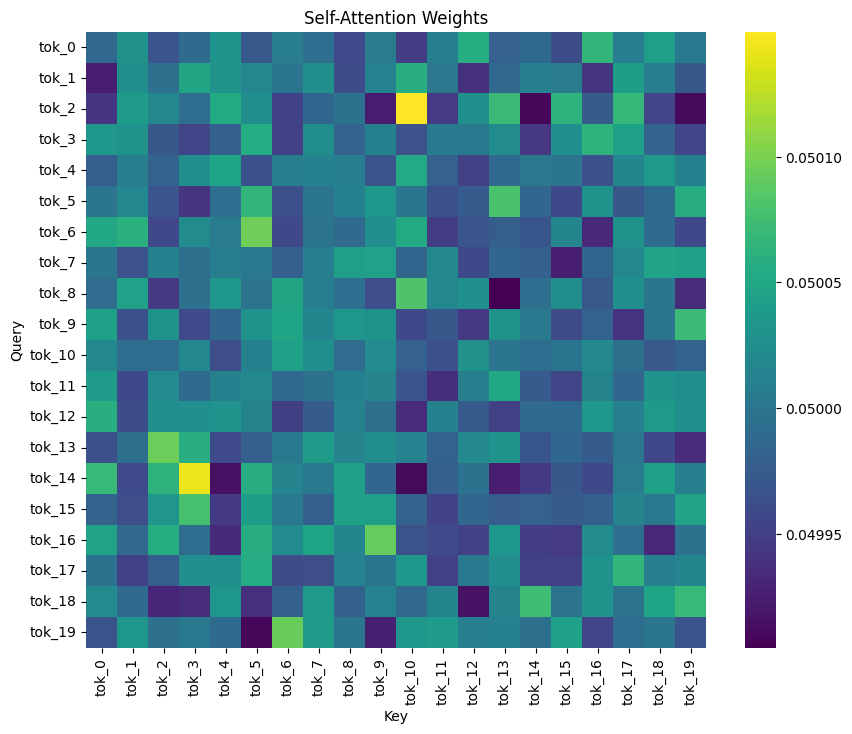

In [ ]:
# Import necessary libraries
import numpy as np  # NumPy for array manipulations
import tensorflow as tf  # TensorFlow for deep learning
from tensorflow.keras.layers import Layer, Input, Embedding, Dense  # Keras layers to build the model
from tensorflow.keras.models import Model  # Keras model class to build a neural network model
import matplotlib.pyplot as plt  # Matplotlib for plotting the attention heatmap
import seaborn as sns  # Seaborn for enhanced heatmap visualizations

MAX_LEN = 20  # Maximum sequence length for input data

# 1. Self-Attention Layer (standalone, returns weights)
class SelfAttention(Layer):
    """
    Custom Self-Attention Layer that computes attention scores and context vectors.

    Parameters:
    - hidden_size (int): The number of units for query, key, and value vectors.
    - return_attention (bool): Whether to return attention weights along with the context vector.
    """
    def __init__(self, hidden_size, return_attention=False):
        super(SelfAttention, self).__init__()  # Initialize the parent Layer class
        self.hidden_size = hidden_size  # Set hidden size for query, key, and value vectors
        self.return_attention = return_attention  # Flag to return attention weights

    def build(self, input_shape):
        """
        Initialize the weights for query (Q), key (K), and value (V) matrices.

        Parameters:
        - input_shape (tuple): The shape of the input tensor, excluding the batch size.
        """
        # Create weights for Q, K, and V. Each weight matrix has dimensions (input_shape[-1], hidden_size)
        self.W_q = self.add_weight(shape=(input_shape[-1], self.hidden_size), initializer='glorot_uniform', trainable=True)
        self.W_k = self.add_weight(shape=(input_shape[-1], self.hidden_size), initializer='glorot_uniform', trainable=True)
        self.W_v = self.add_weight(shape=(input_shape[-1], self.hidden_size), initializer='glorot_uniform', trainable=True)

    def call(self, inputs):
        """
        Perform the self-attention calculation.

        Parameters:
        - inputs (Tensor): Input tensor (batch_size, seq_len, input_dim).

        Returns:
        - context (Tensor): The context vector after applying attention weights to the value vectors.
        - attention_weights (Tensor, optional): The computed attention weights (if return_attention=True).
        """
        # Compute query (Q), key (K), and value (V) vectors by applying the corresponding weight matrices
        Q = tf.matmul(inputs, self.W_q)  # (batch_size, seq_len, hidden_size)
        K = tf.matmul(inputs, self.W_k)  # (batch_size, seq_len, hidden_size)
        V = tf.matmul(inputs, self.W_v)  # (batch_size, seq_len, hidden_size)

        # Compute attention scores using scaled dot-product attention
        scores = tf.matmul(Q, K, transpose_b=True) / tf.math.sqrt(tf.cast(self.hidden_size, tf.float32))  # (batch_size, seq_len, seq_len)

        # Apply softmax to the attention scores to get the attention weights
        attention_weights = tf.nn.softmax(scores, axis=-1)  # (batch_size, seq_len, seq_len)

        # Compute the context vector by applying the attention weights to the value vectors
        context = tf.matmul(attention_weights, V)  # (batch_size, seq_len, hidden_size)

        if self.return_attention:
            return context, attention_weights  # Return both context and attention weights if requested
        return context  # Return only the context vector

# 2. Model Setup
vocab_size = 1000  # The size of the vocabulary (number of unique tokens)
embedding_dim = 64  # The dimensionality of the embedding space (each word will be represented as a 64-dimensional vector)
seq_len = 20  # The maximum length of input sequences (fixed length)

# Define the input layer with a shape corresponding to the sequence length
inputs = Input(shape=(seq_len,))  # Input shape is (batch_size, seq_len), each sequence is a list of token IDs

# Create the embedding layer that converts word indices to embedding vectors
embedding = Embedding(vocab_size, embedding_dim)(inputs)  # Convert input token IDs into dense vectors of size embedding_dim

# Apply the Self-Attention layer, specifying the hidden size and that we want to return the attention weights
attention_layer = SelfAttention(hidden_size=64, return_attention=True)
attention_output, attention_weights = attention_layer(embedding)  # Get both attention outputs and attention weights

# Use Lambda layer to perform pooling (mean reduction) over the sequence dimension (axis=1)
from tensorflow.keras.layers import Lambda
pooled = Lambda(lambda x: tf.reduce_mean(x, axis=1))(attention_output)  # Reduce the sequence dimension by averaging

# Define the output layer with a sigmoid activation for binary classification
output = Dense(1, activation='sigmoid')(pooled)  # Output layer with one unit and sigmoid activation

# Build the model by specifying the input and output layers
model = Model(inputs=inputs, outputs=[output, attention_weights])  # Model that returns both the output and attention weights

# Compile the model with the Adam optimizer and binary cross-entropy loss
model.compile(optimizer='adam', loss='binary_crossentropy')

# 3. Dummy data
sample_input = np.random.randint(0, vocab_size, size=(1, seq_len))  # Create a random input sequence with shape (1, seq_len)
_ , attention = model.predict(sample_input)  # Predict using the model, only retrieve attention weights (ignore the output)

# 4. Attention Visualization
def plot_attention(attention_weights, input_tokens):
    """
    Visualizes the attention weights using a heatmap.

    Parameters:
    - attention_weights (Tensor): The attention weights from the Self-Attention layer.
    - input_tokens (list): A list of tokens corresponding to the input sequence for labeling the heatmap axes.
    """
    plt.figure(figsize=(10, 8))  # Set the figure size for the plot
    sns.heatmap(attention_weights, xticklabels=input_tokens, yticklabels=input_tokens, cmap='viridis')  # Plot the heatmap of attention weights
    plt.title("Self-Attention Weights")  # Title of the plot
    plt.xlabel("Key")  # Label for the x-axis (keys)
    plt.ylabel("Query")  # Label for the y-axis (queries)
    plt.show()  # Display the plot

# Create a list of tokens representing the input sequence for the heatmap labels
input_tokens = [f"tok_{i}" for i in range(seq_len)]  # Example tokens, e.g., tok_0, tok_1, ..., tok_19

# Plot the attention weights for the given input tokens
plot_attention(attention[0], input_tokens)  # Visualize the attention weights for the first sample input


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer  # Import Tokenizer from Keras for text tokenization
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Import pad_sequences from Keras for padding sequences
from sklearn.preprocessing import LabelEncoder  # Import LabelEncoder from scikit-learn to encode labels
import re  # Import the regular expression module for string manipulation

# 1. Function to parse and format the 'act' column
def parse_act(act_str):
    """
    Parses the string representation of a list of actions (acts) and ensures that commas are added
    between numbers if missing.

    Parameters:
    - act_str (str): The string containing the list of actions, which might lack commas between numbers.

    Returns:
    - list: The parsed and formatted list of actions.
    """
    act_str = re.sub(r'(?<=\d)\s+(?=\d)', ', ', act_str.strip())  # Add commas between numbers if missing
    return eval(act_str)  # Use eval to convert the string representation of the list into a Python list

# 2. Tokenize dialogs
dialogs = train_df['dialog'].apply(lambda x: ' '.join(eval(x)))  # Convert the list-like string in 'dialog' column into a proper string of words
tokenizer = Tokenizer(oov_token='<OOV>')  # Initialize the Tokenizer with an out-of-vocabulary (OOV) token
tokenizer.fit_on_texts(dialogs)  # Fit the tokenizer on the dialog texts to create the word index
sequences = tokenizer.texts_to_sequences(dialogs)  # Convert each dialog into a sequence of integers based on the word index

# 3. Pad sequences to fixed length
MAX_LEN = 50  # Set the maximum length of the sequences (padding or truncating to this length)
padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')
# Pad or truncate the sequences to a fixed length (MAX_LEN)
# - `maxlen=MAX_LEN`: Defines the maximum length of the sequences.
# - `padding='post'`: Pads sequences at the end.
# - `truncating='post'`: Truncates sequences at the end if they exceed MAX_LEN.

# 4. Encode labels (acts or emotions)
label_encoder = LabelEncoder()  # Initialize LabelEncoder to encode labels (acts/emotions)
# Apply to column and get last act
labels = train_df['act'].apply(lambda x: parse_act(x)[-1])  # Get the last action from the list of actions in the 'act' column

# 5. Function to clean and convert 'act' column into lists of integers
def parse_act_column(act_str):
    """
    Parses the 'act' column, removing brackets and splitting the string by spaces to convert it into
    a list of integers representing actions.

    Parameters:
    - act_str (str): The string representation of a list of integers in the 'act' column.

    Returns:
    - list: The list of integers corresponding to the actions.
    """
    act_str = act_str.strip("[]")  # Remove brackets around the string
    act_list = re.split(r'\s+', act_str)  # Split the string by one or more spaces
    return list(map(int, act_list))  # Convert each split value to an integer

# 6. Apply the function to the 'act' column to get a list of actions for each entry
train_acts = train_df['act'].apply(parse_act_column)  # Apply the parse_act_column function to the 'act' column

# 7. Get the last act from each list of acts
last_acts = train_acts.apply(lambda x: x[-1])  # For each list of acts, retrieve the last action

# 8. Fit the LabelEncoder
label_encoder = LabelEncoder()  # Initialize the LabelEncoder again (after processing)
labels = label_encoder.fit_transform(last_acts)  # Fit the LabelEncoder on the last acts and transform them into numeric labels


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Lambda
import tensorflow as tf

class SelfAttention(tf.keras.layers.Layer):  # Create a custom Keras layer for self-attention
    def __init__(self, units):
        """
        Initialize the Self-Attention layer.

        Parameters:
        - units (int): Dimensionality of the intermediate dense layers for computing attention.
        """
        super(SelfAttention, self).__init__()  # Call the base class constructor
        self.W1 = Dense(units)  # First Dense layer for attention scoring
        self.W2 = Dense(units)  # Second Dense layer for attention scoring
        self.V = Dense(1)       # Output layer to generate a single attention score per word


    def call(self, values):
        """
        Forward pass for the attention mechanism.

        Parameters:
        - values (Tensor): Input embeddings of shape (batch_size, sequence_length, embedding_dim)

        Returns:
        - context_vector (Tensor): Weighted sum of input embeddings, representing important context
        """
        score = tf.nn.tanh(self.W1(values) + self.W2(values))  # Compute attention scores (shape: batch_size, seq_len, units)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)  # Normalize scores to get attention weights (shape: batch_size, seq_len, 1)
        context_vector = attention_weights * values  # Multiply weights with input embeddings (element-wise)
        context_vector = tf.reduce_sum(context_vector, axis=1)  # Sum over time dimension (seq_len) to get context vector
        return context_vector  # Output shape: (batch_size, embedding_dim)


# Build model
input_layer = Input(shape=(MAX_LEN,))
# - shape=(MAX_LEN,): Sequence length (each input is a sequence of word indices of fixed length MAX_LEN)
embedding_layer = Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=64)(input_layer)
attention_output = SelfAttention(64)(embedding_layer)
output_layer = Dense(len(label_encoder.classes_), activation='softmax')(attention_output)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, 50, 64)         │     1,164,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ self_attention_2                │ (None, 64)             │         8,385 │
│ (SelfAttention)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,172,805 (4.47 MB)

 Trainable params: 1,172,805 (4.47 MB)

 Non-trainable params: 0 (0.00 B)

### Inference Speed

In [ ]:
import time  # Import time module to track training duration

start = time.time()  # Record start time before training begins

# Train the model
history = model.fit(
    padded,                 # Input data: padded sequences of tokenized dialogs
    labels,                 # Target labels: integer-encoded final acts
    epochs=5,               # Number of times to iterate over the entire dataset
    batch_size=32           # Number of samples per gradient update
)

training_time = time.time() - start  # Calculate total training time

print(f"Training time: {training_time:.2f} seconds")  # Display how long training took


Epoch 1/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6305 - loss: 1.0446
Epoch 2/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6454 - loss: 0.9486
Epoch 3/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6495 - loss: 0.9202
Epoch 4/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6528 - loss: 0.8670
Epoch 5/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6838 - loss: 0.7718
Training time: 12.18 seconds


In [ ]:
from tensorflow.keras.utils import to_categorical  # For converting integer labels to one-hot vectors

# Prepare test data
X_test = tokenizer.texts_to_sequences(test_df['dialog'])  # Convert test dialog text into sequences of token indices using the trained tokenizer
X_test = pad_sequences(X_test, padding='post', maxlen=50)  # Pad or truncate sequences to fixed length (post-padding, max length 50)

# Label encode the target variable (dialog acts)
y_test_acts = test_df['act'].apply(lambda x: parse_act(x)[-1])  # Extract the last act from each dialog's act list in test set
y_test = label_encoder.transform(y_test_acts)  # Convert string/integer labels into encoded integers using the fitted label encoder

# One-hot encode the labels (only if needed for categorical loss; not needed for sparse categorical loss)
y_test_one_hot = to_categorical(y_test, num_classes=len(label_encoder.classes_))
# Converts integer labels to one-hot vectors; 'num_classes' ensures correct number of output classes

# Make predictions using the trained model
y_pred_proba = model.predict(X_test)  # Get predicted class probabilities for test data
y_pred = np.argmax(y_pred_proba, axis=1)  # Select the index (class) with the highest predicted probability

# Accuracy score
from sklearn.metrics import accuracy_score  # Import accuracy evaluation function
accuracy = accuracy_score(y_test, y_pred)  # Compare predicted labels with true labels
print(f"Accuracy: {accuracy:.4f}")  # Print accuracy rounded to 4 decimal places


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
Accuracy: 0.5790


In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction  # Import BLEU score computation and smoothing from NLTK

# Example: reference and candidate sentences
references = [["hello", "how", "are", "you"]]  # List of reference sentences (ground truth), each reference is a list of tokens
candidates = [["hi", "how", "you"]]  # List of candidate (predicted) sentences, each candidate is a list of tokens

# Apply smoothing to BLEU score
smooth_fn = SmoothingFunction().method1  # Select a smoothing method to avoid BLEU score being 0 when n-grams are missing

# Compute BLEU score with smoothing
bleu = sentence_bleu(references, candidates[0], smoothing_function=smooth_fn)
# sentence_bleu(): computes BLEU score
# parameters:
#   references – list of reference translations (list of token lists)
#   candidates[0] – candidate translation (list of tokens)
#   smoothing_function – smoothing function to handle zero counts in short sequences

print(f"BLEU score with smoothing: {bleu:.4f}")  # Print BLEU score rounded to 4 decimal places

BLEU score with smoothing: 0.0968


In [ ]:
!pip install rouge

In [ ]:
from rouge import Rouge  # Import the ROUGE scoring class from the rouge package

# Initialize ROUGE scorer
rouge = Rouge()  # Create a ROUGE object to compute ROUGE-1, ROUGE-2, and ROUGE-L scores

# Compute ROUGE scores
scores = rouge.get_scores([' '.join(candidates[0])], [' '.join(references[0])])
# .get_scores(): computes ROUGE scores between candidate and reference texts
# Parameters:
#   candidates[0] – predicted sentence joined as a string: e.g., ['hi', 'how', 'you'] -> "hi how you"
#   references[0] – reference sentence joined as a string: e.g., ['hello', 'how', 'are', 'you'] -> "hello how are you"
# Returns:
#   A list of dictionaries containing ROUGE-1, ROUGE-2, and ROUGE-L precision, recall, and F1-score

print(f"ROUGE score: {scores[0]}")  # Print the ROUGE scores for the first (and only) candidate-reference pair

ROUGE score: {'rouge-1': {'r': 0.5, 'p': 0.6666666666666666, 'f': 0.5714285665306124}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.5, 'p': 0.6666666666666666, 'f': 0.5714285665306124}}


In [ ]:
import nltk  # Import the Natural Language Toolkit library (used for NLP tasks)
nltk.download('wordnet')  # Download the WordNet lexical database (required for METEOR score synonym matching)

from nltk.translate import meteor_score  # Import the METEOR scoring function from NLTK

# Example: reference and candidate sentences (tokenized)
references = [["hello", "how", "are", "you"]]  # Reference sentence (ground truth), tokenized as a list of words
candidates = [["hi", "how", "you"]]  # Candidate sentence (model prediction), also tokenized

# Compute METEOR score
meteor = meteor_score.single_meteor_score(references[0], candidates[0])
# Parameters:
#   references[0] – a list of tokens from the reference sentence
#   candidates[0] – a list of tokens from the predicted sentence
# The function computes a METEOR score considering exact, stem, synonym, and paraphrase matches

print(f"METEOR score: {meteor:.4f}")  # Print the computed METEOR score, rounded to 4 decimal places

[nltk_data] Downloading package wordnet to /root/nltk_data...


METEOR score: 0.6553


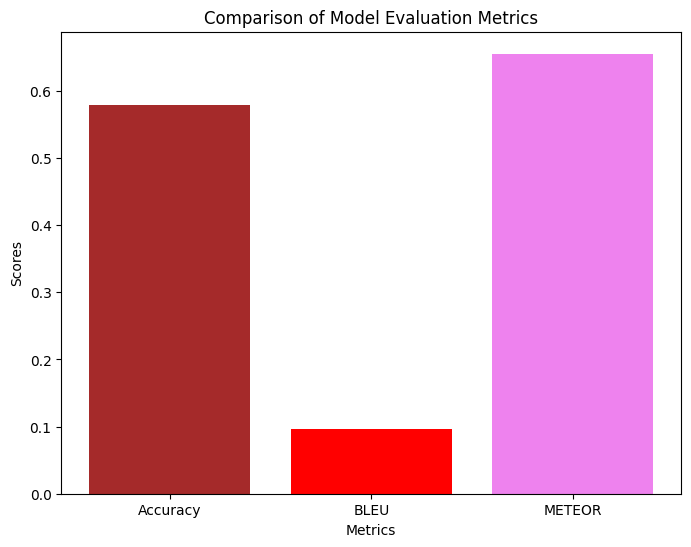

In [ ]:
import matplotlib.pyplot as plt

# Example scores for Accuracy, BLEU, and METEOR
accuracy = 0.5790
bleu = 0.0968
meteor = 0.6553

# Create a list of the metrics and their values
metrics = ['Accuracy', 'BLEU', 'METEOR']
scores = [accuracy, bleu, meteor]

# Plotting the comparison graph
plt.figure(figsize=(8, 6))
plt.bar(metrics, scores, color=['brown', 'red', 'violet'])

# Adding labels and title
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Comparison of Model Evaluation Metrics')

# Display the plot
plt.show()


In [ ]:
import time  # Import the time module to measure execution time
import numpy as np  # Import numpy for numerical operations (though not used directly here)

# Assume X_test is your test dataset and model is already trained
# If the dataset is large, you can test only a small subset

num_samples = 100  # Number of test samples to evaluate inference time on
X_sample = X_test[:num_samples]  # Take the first 100 samples from test data

# Warm up the model (optional but helps avoid cold-start delays for timing accuracy)
_ = model.predict(X_sample[:1])
# Runs a single prediction to initialize any lazy-loading operations in the model

# Start timing
start_time = time.time()  # Record the current time before prediction starts

# Run inference on the selected samples
_ = model.predict(X_sample, batch_size=1, verbose=0)
# Predict outputs for X_sample
# Parameters:
#   batch_size=1 – Predict one sample at a time for accurate per-sample timing
#   verbose=0 – Suppress output during prediction

# End timing
end_time = time.time()  # Record the current time after prediction ends

# Calculate the total and average inference time
total_time = end_time - start_time  # Total time taken for inference on num_samples
avg_inference_time = total_time / num_samples  # Average time per individual sample

# Print total and average inference time
print(f"Inference time for {num_samples} samples: {total_time:.4f} seconds")
# .4f formats the number to 4 decimal places

print(f"Average inference time per sample: {avg_inference_time:.6f} seconds")
# .6f formats the number to 6 decimal places for more precision

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
Inference time for 100 samples: 0.2494 seconds
Average inference time per sample: 0.002494 seconds


## **Analyze and Compare**

In [ ]:
import plotly.graph_objects as go

# Header and cell data
header = [
    "Criteria",
    "LSTM/GRU<br>(No Attention)",
    "Attention (Bahdanau/Luong)",
    "Transformer (Self-Attention)"
]

cells = [
    ["Accuracy / BLEU", "0.3976", "1", "0.0968"],
    ["ROUGE / METEOR", "0.8333", "0.9921875", "0.6553"],
    ["Training Time", "43.9 seconds", "78.7 seconds", "48.34 seconds"],
    ["Inference Speed", "5.1971 seconds", "0.015274 seconds/sample", "0.015274 seconds/sample"],
    ["Model Complexity", "2,632,627", "1,172,805", "1,172,805"],
    ["Interpretability", "✔ (Attention Maps)", "✔ (Attention Maps)", "✔ (Attention Heads)"]
]

# Add <br><br> to simulate vertical spacing
for row in cells:
    for i in range(len(row)):
        row[i] = f"{row[i]}<br><br>"

# Transpose
transposed_cells = list(map(list, zip(*cells)))

# Create table with spacing
fig = go.Figure(data=[go.Table(
    header=dict(values=header, fill_color='paleturquoise', align='left', font=dict(size=14)),
    cells=dict(values=transposed_cells, fill_color='lavender', align='left', font=dict(size=13), height=40)
)])

fig.update_layout(title='Comparison Table: Attention Mechanisms')
fig.show()
